<a href="https://colab.research.google.com/github/Sean-1005/JSC270_A4/blob/main/JSC270_A4Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Question 1** Sentiment Analysis with a Common Twitter Dataset

In [16]:
from google.colab import files
df_train = files.upload()

Saving covid-tweets-train.csv to covid-tweets-train (2).csv


In [17]:
from google.colab import files
df_test = files.upload()

Saving covid-tweets-test.csv to covid-tweets-test (2).csv


In [18]:
import pandas as pd
import numpy as np
import io

df_train = pd.read_csv(io.BytesIO(df_train['covid-tweets-train.csv']))
df_test = pd.read_csv(io.BytesIO(df_test['covid-tweets-test.csv']))

In [19]:
print(df_test["OriginalTweet"][:6].all())
print(df_test["OriginalTweet"][:8].all())
print(df_test["Sentiment"].tail(10))

Do you remember the last time you paid $2.99 a gallon for regular gas in Los Angeles?Prices at the pump are going down. A look at how the #coronavirus is impacting prices. 4pm @ABC7 https://t.co/Pyzq8YMuV5


Prices of surgical masks have increased six-fold, N95 respirators have more than trebled &amp; gowns cost twice as much"-@DrTedros #coronavirus
3788    1
3789    2
3790    2
3791    0
3792    0
3793    2
3794    0
3795    1
3796    0
3797    2
Name: Sentiment, dtype: int64


In [20]:
#cleaning data
df_train['Sentiment'][18450] = '0'
df_train['Sentiment'][36128] = '2'

df_train.dropna(subset = ['Sentiment'], inplace = True)
df_train['Sentiment']  = df_train['Sentiment'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(A) Consider the training data. What is the balance between the three classes? In other words, what
proportion of the observations (in the training set) belong to each class?


In [21]:
df_train.Sentiment.value_counts()
df_train.info()
df_train["Sentiment"].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41153 entries, 0 to 41154
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     41153 non-null  int64 
 1   OriginalTweet  41153 non-null  object
 2   Sentiment      41153 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ MB


2    18043
0    15398
1     7712
Name: Sentiment, dtype: int64

The proportion of 'positive' is $\frac{18043}{41153}=43.84\%$. 

The proportion of 'neutral' is $\frac{7712}{41153}=18.74\%$.

The proportion of 'negative' is $\frac{15398}{41153}=37.42\%$.

(B) Tokenize the tweets.

In [22]:
# Create a new column in df_train and df_test that contains token lists
def tokenize(df):
  token = []
  for tweet in df['OriginalTweet']:
    token.append(tweet.split())
  return token

df_train['tokens'] = tokenize(df_train)
df_test['tokens'] = tokenize(df_test)

(C) Remove URL tokens

In [23]:
import re

def no_links(df):
  tokens_no_links = []
  for tweet in df['tokens']:
    tokens_no_links.append([re.sub('^http.*$','', t) for t in tweet])
  return tokens_no_links

df_train['tokens'] = no_links(df_train)
df_test['tokens'] = no_links(df_test)

(D) Remove all punctuation

In [24]:
# Remove all punctuations
temp_train = []
temp_test = []
tokens_no_punct_train = []
tokens_no_punct_test = []

for row in df_train["tokens"]:
  temp_train.append([re.sub('[^\w\s]','', t) for t in row])

for row in temp_train:
  tokens_no_punct_train.append([w for w in row if w != ''])

for row in df_test["tokens"]:
  temp_test.append([re.sub('[^\w\s]','', t) for t in row])

for row in temp_test:
  tokens_no_punct_test.append([w for w in row if w != ''])

# Covert all row into lowercase
tokens_lowercase_train = []
tokens_lowercase_test = []
for row in tokens_no_punct_train:
  tokens_lowercase_train.append([t.lower() for t in row])

for row in tokens_no_punct_test:
  tokens_lowercase_test.append([t.lower() for t in row])

df_train["tokens"] = tokens_lowercase_train
df_test["tokens"] = tokens_lowercase_test


（E）Stemming

In [25]:
from nltk.stem.porter import *

stemmer = PorterStemmer()

def stem(df):
  stemed = []
  for tweet in df['tokens']:
    stemed.append([stemmer.stem(w) for w in tweet])
  return stemed

df_train["tokens_stem"] = stem(df_train)
df_test["tokens_stem"] = stem(df_test)

(F) Remove stopwords

In [26]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

sw = stopwords.words('english')[:75]

tokens_no_sw_train = []
tokens_no_sw_test = []

for row in df_train['tokens_stem']:
  tokens_no_sw_train.append([w for w in row if w not in sw])

df_train['tokens_stem'] = tokens_no_sw_train

for row in df_test['tokens_stem']:
  tokens_no_sw_test.append([w for w in row if w not in sw])

df_test['tokens_stem'] = tokens_no_sw_test

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


(G) Convert lists of words into vectors of word counts

In [68]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split


# Separate labels from features, converting to numpy arrays
X_train, y_train = df_train['tokens_stem'].to_numpy(), df_train['Sentiment'].to_numpy()
X_test, y_test = df_test['tokens_stem'].to_numpy(), df_test['Sentiment'].to_numpy()

def override_fcn(doc):
  # We expect a list of tokens as input
  return doc

vocab = (np.unique(np.concatenate(X_train))).shape[0]

# Count Vectorizer
count_vec = CountVectorizer(
    analyzer='word',
    tokenizer= override_fcn,
    preprocessor= override_fcn,
    token_pattern= None,
    max_features = 1000)

# Remember this output is a Scipy Sparse Array
X = np.concatenate((X_train, X_test), axis=0)
counts = count_vec.fit_transform(X)



(H) Fit Naive Bayes model

In [69]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
X_train, X_test = counts[:np.size(X_train), : ], counts[np.size(X_train):, :]

nb = MultinomialNB()
nb.fit(X_train, y_train)

predict = nb.predict(X_test)

print('Test accuracy with simple Naive Bayes:',accuracy_score(y_test, predict))

Test accuracy with simple Naive Bayes: 0.6627172195892576


In [70]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41153 entries, 0 to 41154
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     41153 non-null  int64 
 1   OriginalTweet  41153 non-null  object
 2   Sentiment      41153 non-null  int64 
 3   tokens         41153 non-null  object
 4   tokens_stem    41153 non-null  object
 5   tokens_lem     41153 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.2+ MB


In [74]:
positive = []
neutral = []
negative = []

X, y = df_train['tokens_stem'].to_numpy(), df_train['Sentiment'].to_numpy()

for i in range(len(X)):
  if y[i] == 0:
    negative.append(X[i])
  elif y[i] == 1:
    neutral.append(X[i])
  else:
    positive.append(X[i])

count_vec_postop = CountVectorizer(
    analyzer='word',
    tokenizer= override_fcn,
    preprocessor= override_fcn,
    token_pattern= None,
    max_features = 1000)

# Remember this output is a Scipy Sparse Array
count_vec_postop.fit_transform(positive)

# Print the names of each of the features (1000 total))
token_freq_p = count_vec_postop.vocabulary_

count_vec_neutop = CountVectorizer(
    analyzer='word',
    tokenizer= override_fcn,
    preprocessor= override_fcn,
    token_pattern= None,
    max_features = 1000)

# Remember this output is a Scipy Sparse Array
count_vec_neutop.fit_transform(neutral)

# Print the names of each of the features (1000 total))
token_freq_neu = count_vec_neutop.vocabulary_

count_vec_negtop = CountVectorizer(
    analyzer='word',
    tokenizer= override_fcn,
    preprocessor= override_fcn,
    token_pattern= None,
    max_features = 1000)

# Remember this output is a Scipy Sparse Array
count_vec_negtop.fit_transform(negative)

# Print the names of each of the features (1000 total))
token_freq_n = count_vec_negtop.vocabulary_


sort_orders_p = sorted(token_freq_p.items(), key=lambda x: x[1], reverse=True)
sort_orders_neu = sorted(token_freq_neu.items(), key=lambda x: x[1], reverse=True)
sort_orders_n = sorted(token_freq_n.items(), key=lambda x: x[1], reverse=True)

p = sorted(token_freq_p, key=token_freq_p.get, reverse=True)
neu = sorted(token_freq_neu, key=token_freq_neu.get, reverse=True)
n = sorted(token_freq_n, key=token_freq_n.get, reverse=True)

print("Top 5 words for 2: ", p[:5])
print("Top 5 words for 1: ", neu[:5])
print("Top 5 words for 0: ", n[:5])

Top 5 words for 2:  ['â', 'youâr', 'yet', 'yesterday', 'year']
Top 5 words for 1:  ['â', 'youâr', 'youtub', 'york', 'yet']
Top 5 words for 0:  ['â', 'youâr', 'yet', 'yesterday', 'year']


(I) ROC curve

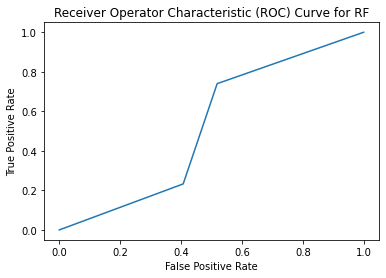

In [41]:
from sklearn.metrics import accuracy_score, roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, predict, pos_label = 1)

plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic (ROC) Curve for RF')
plt.show()

J) using TF-IDF vectors

In [60]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split


# Separate labels from features, converting to numpy arrays
X_train, y_train = df_train['tokens_stem'].to_numpy(), df_train['Sentiment'].to_numpy()
X_test, y_test = df_test['tokens_stem'].to_numpy(), df_test['Sentiment'].to_numpy()

def override_fcn(doc):
  # We expect a list of tokens as input
  return doc

vocab = (np.unique(np.concatenate(X_train))).shape[0]

# Count Vectorizer
count_vec = CountVectorizer(
    analyzer='word',
    tokenizer= override_fcn,
    preprocessor= override_fcn,
    token_pattern= None,
    max_features = 1000)

# Remember this output is a Scipy Sparse Array
X = np.concatenate((X_train, X_test), axis=0)
counts = count_vec.fit_transform(X)

In [61]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
######for training data
tfidf = TfidfTransformer()
tfs1 = tfidf.fit_transform(counts)

# Let's use the TFIDF counts for modelling
X = tfs1.toarray()
X_train, X_test = X[:np.size(X_train), : ], X[np.size(X_train):, :]

# Let's fit the Naive Bayes model to our training data
nb = MultinomialNB()
# Fit model to training data
nb.fit(X_train, y_train)
# Predict on test data
y_preds = nb.predict(X_test)
X_test, y_test = df_test['tokens_stem'].to_numpy(), df_test['Sentiment'].to_numpy()
print('Test accuracy with simple Naive Bayes:',accuracy_score(y_test,y_preds))


(K) Using lemmatization

In [64]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

lem_tokens = []
for row in df_train['tokens']:
  lem_tokens.append([lemmatizer.lemmatize(t) for t in row])

df_train['tokens_lem'] = lem_tokens

lem_tokens2 = []
for row in df_test['tokens']:
  lem_tokens2.append([lemmatizer.lemmatize(t) for t in row])

df_test['tokens_lem'] = lem_tokens2


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [65]:
sw_lem = stopwords.words('english')[:100]

tokens_no_sw_train_lem = []
tokens_no_sw_test_lem = []

for row in df_train['tokens_lem']:
  tokens_no_sw_train_lem.append([w for w in row if w not in sw_lem])

df_train['tokens_lem'] = tokens_no_sw_train_lem

for row in df_test['tokens_lem']:
  tokens_no_sw_test_lem.append([w for w in row if w not in sw_lem])

df_test['tokens_lem'] = tokens_no_sw_test_lem
df_train

,Unnamed: 0,OriginalTweet,Sentiment,tokens,tokens_stem,tokens_lem
0,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,"[menyrbie, phil_gahan, chrisitv, and, and]","[menyrbi, phil_gahan, chrisitv]","[menyrbie, phil_gahan, chrisitv]"
1,1,advice Talk to your neighbours family to excha...,2,"[advice, talk, to, your, neighbours, family, t...","[advic, talk, to, neighbour, famili, to, excha...","[advice, talk, neighbour, family, exchange, ph..."
2,2,Coronavirus Australia: Woolworths to give elde...,2,"[coronavirus, australia, woolworths, to, give,...","[coronaviru, australia, woolworth, to, give, e...","[coronavirus, australia, woolworth, give, elde..."
3,3,My food stock is not the only one which is emp...,2,"[my, food, stock, is, not, the, only, one, whi...","[food, stock, not, onli, one, empti, pleas, do...","[food, stock, not, only, one, empty, please, d..."
4,4,"Me, ready to go at supermarket during the #COV...",0,"[me, ready, to, go, at, supermarket, during, t...","[readi, to, go, supermarket, dure, covid19, ou...","[ready, go, supermarket, covid19, outbreak, no..."
...,...,...,...,...,...,...
41150,41150,Airline pilots offering to stock supermarket s...,1,"[airline, pilots, offering, to, stock, superma...","[airlin, pilot, offer, to, stock, supermarket,...","[airline, pilot, offering, stock, supermarket,..."
41151,41151,Response to complaint not provided citing COVI...,0,"[response, to, complaint, not, provided, citin...","[respons, to, complaint, not, provid, cite, co...","[response, complaint, not, provided, citing, c..."
41152,41152,You know itÂs getting tough when @KameronWild...,2,"[you, know, itâs, getting, tough, when, kamero...","[know, itâ, get, tough, when, kameronwild, rat...","[know, itâs, getting, tough, when, kameronwild..."
41153,41153,Is it wrong that the smell of hand sanitizer i...,1,"[is, it, wrong, that, the, smell, of, hand, sa...","[wrong, smell, hand, sanit, start, to, turn, o...","[wrong, smell, hand, sanitizer, starting, turn..."


In [66]:
X_train, y_train = df_train['tokens_lem'].to_numpy(), df_train['Sentiment'].to_numpy()
X_test, y_test = df_test['tokens_lem'].to_numpy(), df_test['Sentiment'].to_numpy()

def override_fcn(doc):
  # We expect a list of tokens as input
  return doc

# Count Vectorizer
count_vec = CountVectorizer(
    analyzer='word',
    tokenizer= override_fcn,
    preprocessor= override_fcn,
    token_pattern= None,
    max_features = 1000)

# Remember this output is a Scipy Sparse Array
X = np.concatenate((X_train, X_test), axis=0)
counts = count_vec.fit_transform(X)

In [67]:
tfidf = TfidfTransformer()
tfs1 = tfidf.fit_transform(counts)

# Let's use the TFIDF counts for modelling
X = tfs1.toarray()
X_train, X_test = X[:np.size(X_train), : ], X[np.size(X_train):, :]

# Let's fit the Naive Bayes model to our training data
nb = MultinomialNB()
# Fit model to training data

nb.fit(X_train, y_train)
# Predict on test data
y_preds = nb.predict(X_test)
X_test, y_test = df_test['tokens_lem'].to_numpy(), df_test['Sentiment'].to_numpy()
print('Test accuracy with simple Naive Bayes:',accuracy_score(y_test,y_preds))

Test accuracy with simple Naive Bayes: 0.6453396524486572
